In [1]:
from pathlib import Path

import sys
import os
sys.path.append(os.path.abspath("../src"))

from utils import load_merfish_signal_df, load_banksy_result, load_merfish_data, load_boundaries_data, load_scRNA_data
from utils import extract_cell_vsi
from plot import plot_VSI_map, plot_vsi_distribution_comparison, plot_normalized_histogram, plot_vsi_qqplot
from plot import histogram_comparison, plot_marker_signals, plot_annotate_heatmap

import numpy as np
import pandas as pd
from IPython.display import display

In [24]:
import matplotlib.pyplot as plt

### data

#### Results of Ovrlpy
`ovrl.py` was executed in separate notebooks:  
- Ovrlpy_all_transcripts.ipynb  
- Ovrlpy_no_MOD_markers.ipynb  
- Ovrlpy_no_MOD1_markers.ipynb  
- Ovrlpy_no_MOD2_markers.ipynb

In this notebook, we use the output:  
- Signal integrity  
- Signal strength  

generated from above notebooks.  

In [2]:
ovrlpy_result_folder = Path("../data/results/VSI/")
signal_integrity = np.loadtxt(ovrlpy_result_folder/"SignalIntegrity.txt")
signal_strength = np.loadtxt(ovrlpy_result_folder/"SignalStrength.txt")

In [3]:
# exclude MOD marker signals
nonMOD_signal_integrity = np.loadtxt(ovrlpy_result_folder/"SignalIntegrity_exMOD.txt")
nonMOD_signal_strength = np.loadtxt(ovrlpy_result_folder/"SignalStrength_exMOD.txt")

In [4]:
# exclude MOD marker signals
nonMOD1_signal_integrity = np.loadtxt(ovrlpy_result_folder/"SignalIntegrity_exMOD1.txt")
nonMOD1_signal_strength = np.loadtxt(ovrlpy_result_folder/"SignalStrength_exMOD1.txt")

In [5]:
# exclude MOD marker signals
nonMOD2_signal_integrity = np.loadtxt(ovrlpy_result_folder/"SignalIntegrity_exMOD2.txt")
nonMOD2_signal_strength = np.loadtxt(ovrlpy_result_folder/"SignalStrength_exMOD2.txt")

In [6]:
# doublets
doublets_all = pd.read_csv(ovrlpy_result_folder/"doublets_df.csv")
doublets_exMOD = pd.read_csv(ovrlpy_result_folder/"doublets_exMOD_df.csv")
doublets_exMOD1 = pd.read_csv(ovrlpy_result_folder/"doublets_exMOD1_df.csv")
doublets_exMOD2 = pd.read_csv(ovrlpy_result_folder/"doublets_exMOD2_df.csv")

#### Signals in the Tissue Section

In [7]:
MERFISH_data_folder_path = Path("../data/mouse_hypothalamus/MERFISH/")

In [8]:
signal_coordinate_df, coordinate_x_m, coordinate_y_m = load_merfish_signal_df(MERFISH_data_folder_path/"merfish_barcodes_example.csv")

#### Results of BANKSY

In [9]:
banksy_folder_path = Path("../data/banksy_results/")

In [10]:
banksy_result = load_banksy_result(banksy_folder_path/"banksy_cluster.txt", coordinate_x_m, coordinate_y_m)

In [11]:
MOD1_df = banksy_result[banksy_result['banksy_cluster'] == 8]
MOD2_df = banksy_result[banksy_result['banksy_cluster'] == 7]

differentially expressed genes identified by BANKSY

In [12]:
# all differentially expressed genes
DE_genes = ['Mlc1', 'Dgkk', 'Cbln2', 'Syt4', 'Gad1', 'Plin3', 'Gnrh1', 'Sln', 'Gjc3', 'Mbp', 'Lpar1', 'Trh', 'Ucn3', 'Cck']
# DE_genes_MOD2: 7
DE_genes_MOD2 = ['Mlc1', 'Dgkk', 'Cbln2', 'Syt4', 'Gad1', 'Plin3', 'Gnrh1', 'Sln', 'Gjc3']
# DE_genes_MOD1: 8
DE_genes_MOD1 = ['Mbp', 'Lpar1', 'Trh', 'Ucn3', 'Cck']

In [13]:
DE_gene_signals = signal_coordinate_df[signal_coordinate_df['gene'].isin(DE_genes)].copy()
MOD1_signals = signal_coordinate_df[signal_coordinate_df['gene'].isin(DE_genes_MOD1)].copy()
MOD2_signals = signal_coordinate_df[signal_coordinate_df['gene'].isin(DE_genes_MOD2)].copy()

In [14]:
Gene_Group = pd.DataFrame([0,0,0,0,0,0,0,0,0,1,1,1,1,1], columns=['cluster'])

#### Segmentation Dataset

In [15]:
merfish_data = load_merfish_data(MERFISH_data_folder_path / "merfish_all_cells.csv", 
                                 banksy_result, coordinate_x_m, coordinate_y_m, 
                                 animal_id=1, bregma_value=-0.24)

In [16]:
MOD_merfish = merfish_data[(merfish_data['banksy']==7) | (merfish_data['banksy']==8)]
MOD_merfish = MOD_merfish.sort_values(by='banksy')

common_genes = [gene for gene in DE_genes if gene in MOD_merfish.columns]
MOD_merfish_DE = MOD_merfish[common_genes].T

MOD_banksy = MOD_merfish['banksy']

#### Cell boundaries

In [17]:
boundaries_df = load_boundaries_data(MERFISH_data_folder_path/'cellboundaries_example_animal.csv', 
                                     merfish_data, coordinate_x_m, coordinate_y_m)

In [18]:
MOD_boundaries = boundaries_df[(boundaries_df['banksy'] == 8) | (boundaries_df['banksy'] == 7)]
MOD1_boundaries = boundaries_df[boundaries_df['banksy'] == 8]
MOD2_boundaries = boundaries_df[boundaries_df['banksy'] == 7]
other_boundaries = boundaries_df[~boundaries_df['banksy'].isin([8, 7])]

#### Matched Single-Cell RNA Sequencing

In [19]:
data_path = Path("../data/mouse_hypothalamus/SingleCell/")
mtx_path = data_path / "GSE113576_matrix.mtx"
barcodes_path = data_path / "GSE113576_barcodes.tsv"
genes_path = data_path / "GSE113576_genes.tsv"
meta_path = data_path / "aau5324_Moffitt_Table-S1.xlsx"

In [20]:
cell_class_dict = {
    'Astrocytes': 'Astrocytes',
    'Endothelial': 'Endothelial',
    'Ependymal': 'Ependymal',
    'Excitatory': 'Excitatory',
    'Fibroblast': 'Fibroblast',
    'Immature oligodendrocyte': 'OD immature',
    'Inhibitory': 'Inhibitory',
    'Macrophage': 'Macrophage',
    'Mature oligodendrocyte': 'OD mature',
    'Microglia': 'Microglia',
    'Mural': 'Mural',
    'Newly formed oligodendrocyte': 'OD newly formed',
}

adata = load_scRNA_data(
    mtx_path, 
    barcodes_path, 
    genes_path, 
    meta_path, 
    cell_class_filter = cell_class_dict
)

In [ ]:
sc_data = adata.to_df()
sc_DE_MOD1_df = sc_data[DE_genes_MOD1]
sc_DE_MOD2_df = sc_data[DE_genes_MOD2]
sc_DE = pd.concat([sc_DE_MOD1_df, sc_DE_MOD2_df], axis=1)

sc_cell_class = adata.obs['Cell_class']

### cell type map

In [25]:
set(merfish_data['Cell_class'])

{'Astrocyte',
 'Endothelial',
 'Ependymal',
 'Excitatory',
 'Inhibitory',
 'Microglia',
 'OD Immature',
 'OD Mature',
 'Pericytes'}

C:\Users\tomo\AppData\Local\Temp\ipykernel_9012\2674345472.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20b', len(unique_other_labels))


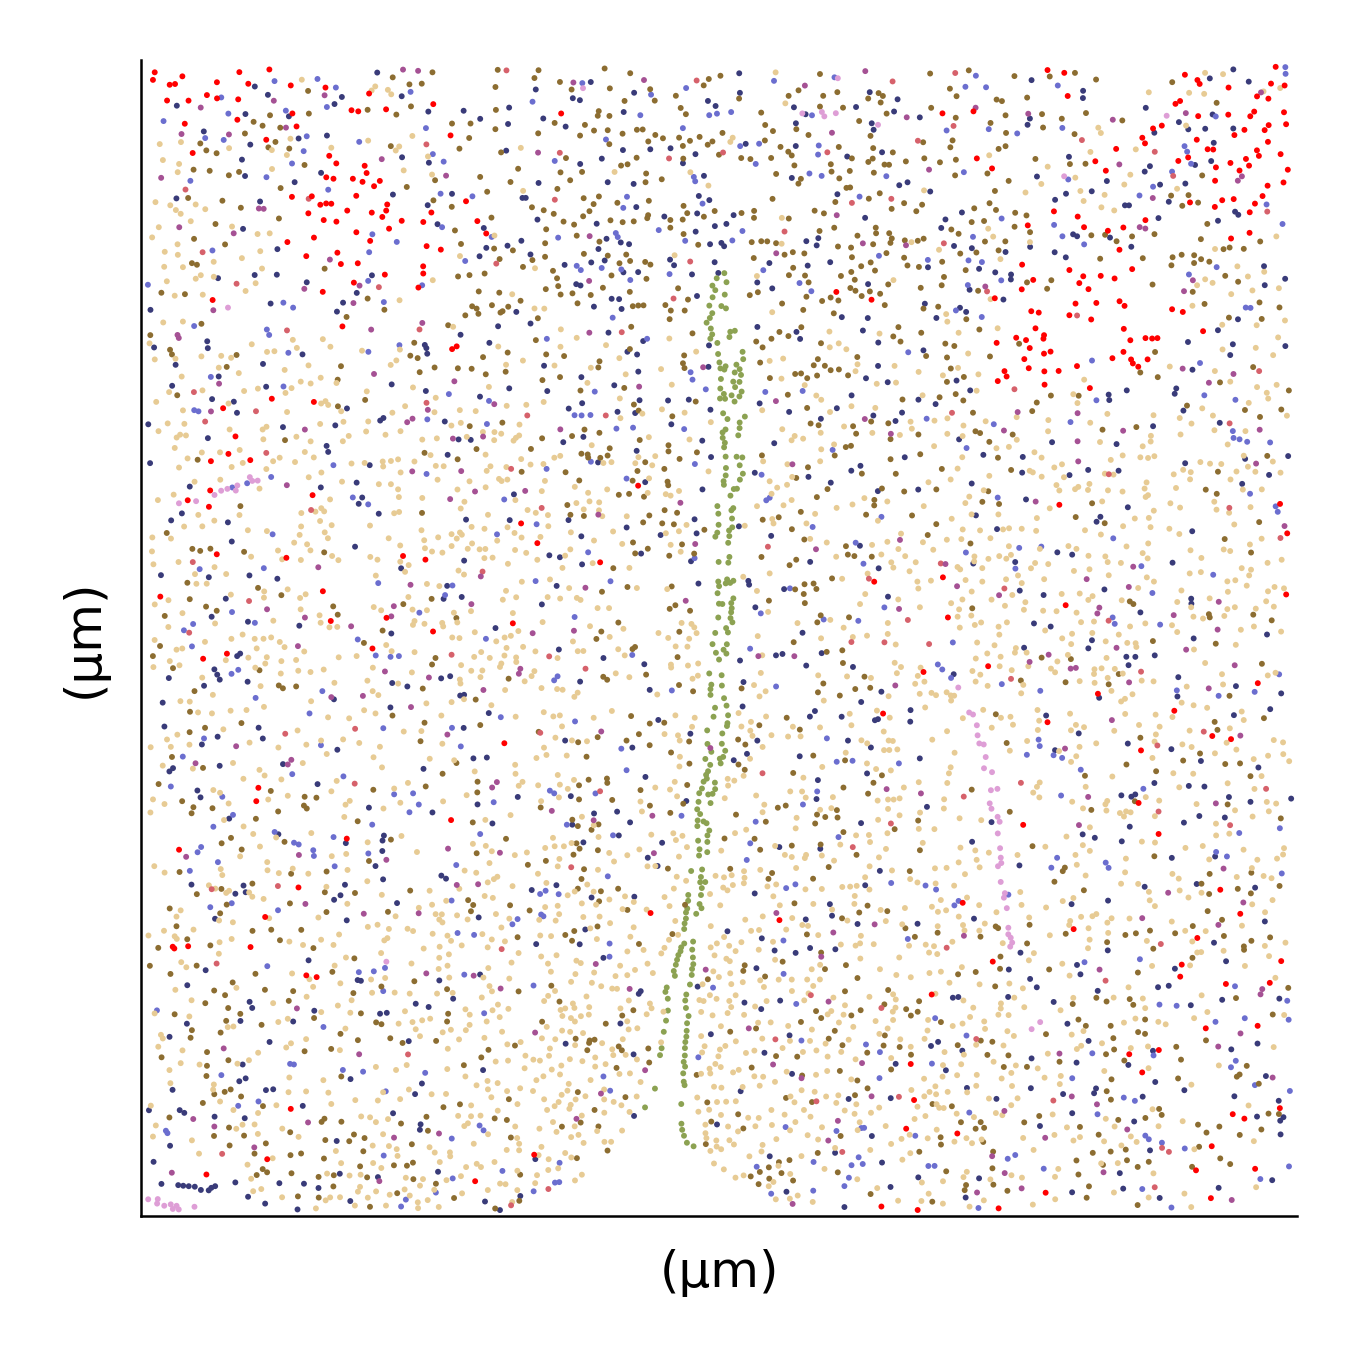

In [ ]:
all_labels = merfish_data['Cell_class'].unique()
# Preferred hard-coded label colors
color_map = {'OD Mature': 'red'}
# Assign tab20b colors to other clusters
unique_other_labels = [label for label in all_labels if label not in color_map]
colormap = plt.cm.get_cmap('tab20b', len(unique_other_labels))
other_colors = {
    label: colormap(i) for i, label in enumerate(sorted(unique_other_labels))
}
cmap = {**color_map, **other_colors}

# Map colors to data points
colors = merfish_data['Cell_class'].map(cmap)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=600)

# Scatter plot for cells
ax.scatter(
    merfish_data["x"],
    merfish_data["y"],
    s=0.5,
    c=colors,
    edgecolors='none'
)
    
ax.set_xticks([])
ax.set_yticks([])
ax.spines[["top", "right"]].set_visible(False)
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_linewidth(0.3)
plt.xlim(-5,1805)
plt.ylim(-5,1805)
# plt.title('Mouse Hypothalamus', fontsize=6, fontweight='light')
plt.xlabel('(μm)', fontsize=6)
plt.ylabel('(μm)', fontsize=6)
plt.tight_layout()  
plt.show()


### MODs map

In [43]:
MOD_df = banksy_result[(banksy_result['banksy_cluster']==7) | (banksy_result['banksy_cluster']==8)]

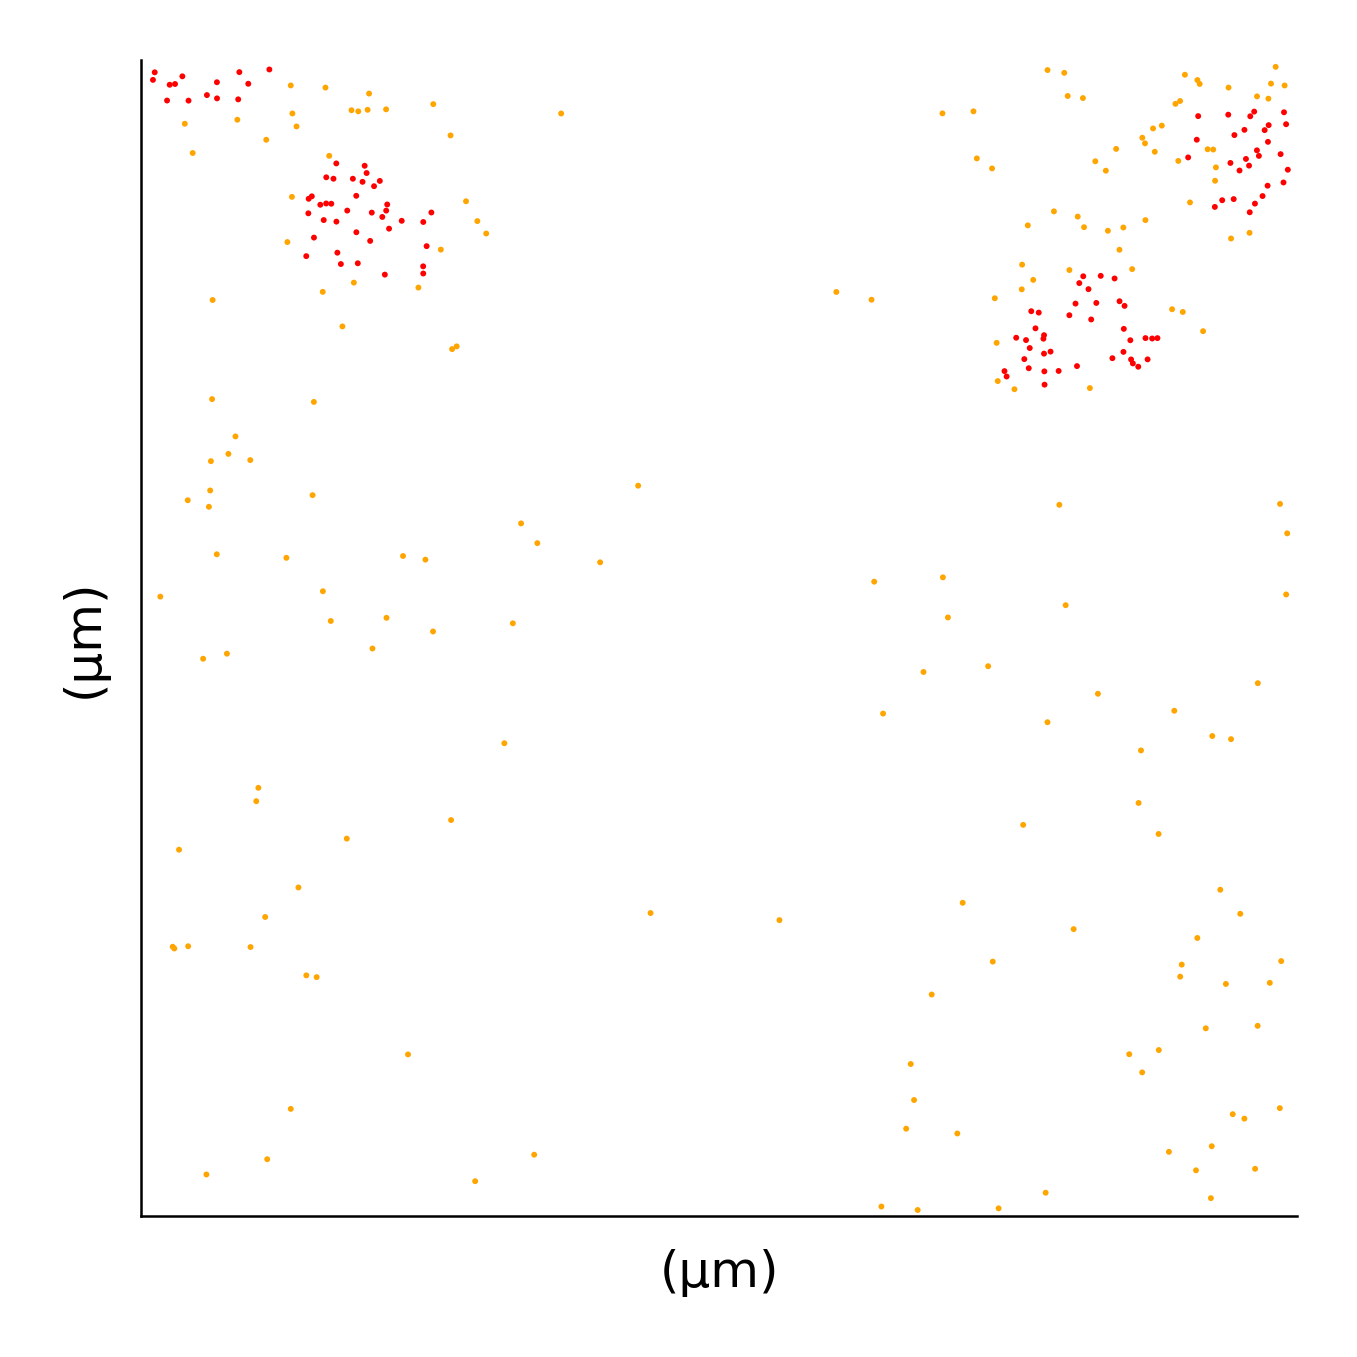

In [44]:
color_map = {8: 'red', 7: 'orange'}
# Map colors to data points
colors = MOD_df['banksy_cluster'].map(color_map)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=600)

# Scatter plot for cells
ax.scatter(
    MOD_df["x"],
    MOD_df["y"],
    s=0.5,
    c=colors,
    edgecolors='none'
)
    
ax.set_xticks([])
ax.set_yticks([])
ax.spines[["top", "right"]].set_visible(False)
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_linewidth(0.3)
plt.xlim(-5,1805)
plt.ylim(-5,1805)
# plt.title('Mouse Hypothalamus', fontsize=6, fontweight='light')
plt.xlabel('(μm)', fontsize=6)
plt.ylabel('(μm)', fontsize=6)
plt.tight_layout()  
plt.show()


### VSI map

In [154]:
from matplotlib.colors import LinearSegmentedColormap

BIH_CMAP = LinearSegmentedColormap.from_list(
    "BIH",
    [
        "#430541",
        "mediumvioletred",
        "violet",
        "powderblue",
        "powderblue",
        "white",
        "white",
    ][::-1],
)

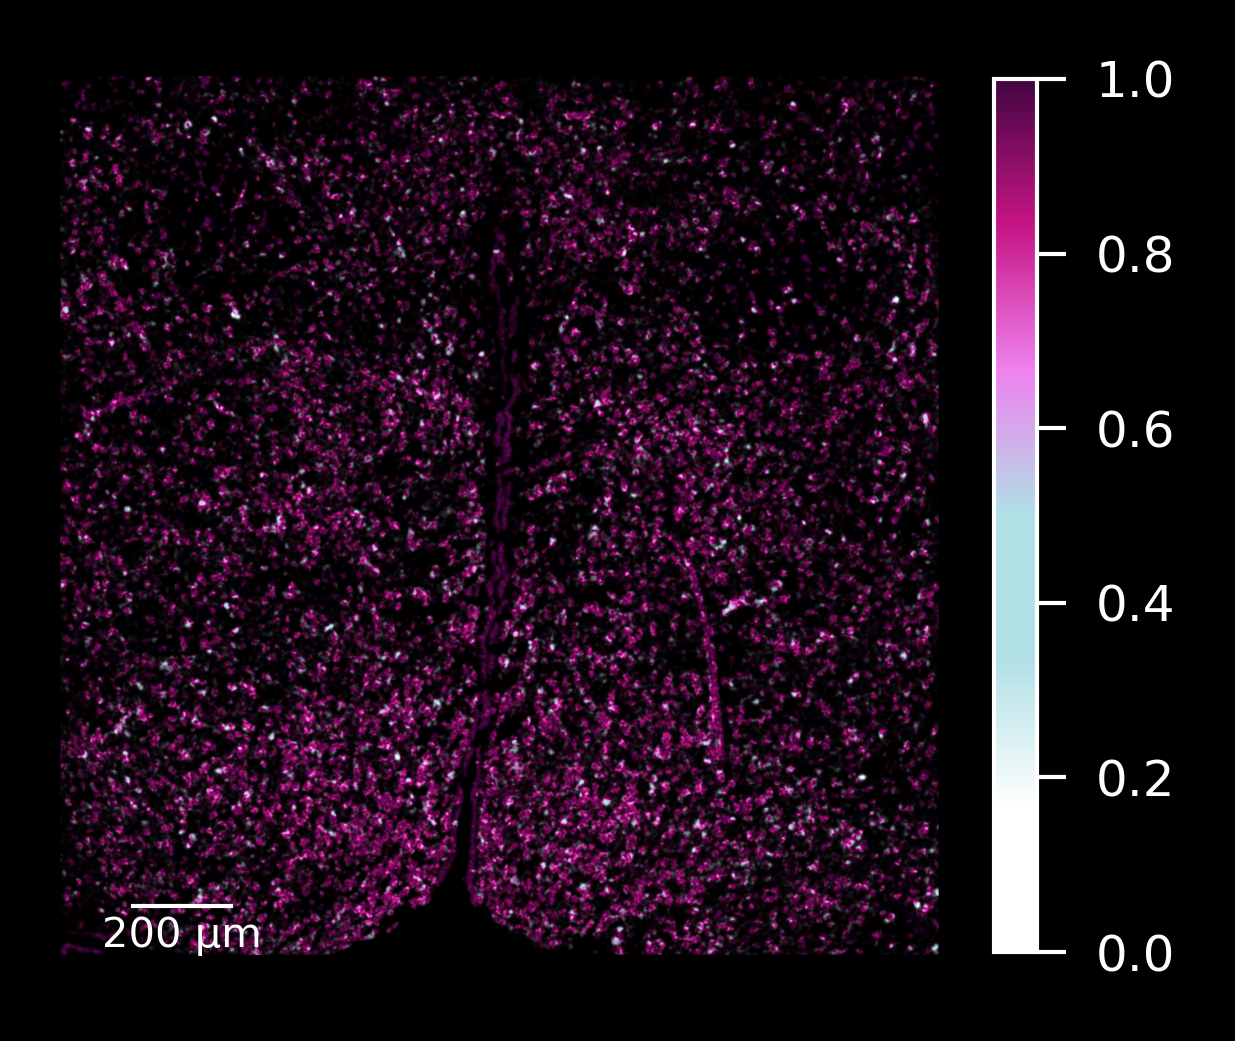

In [163]:
cell_integrity = signal_integrity
cell_strength = signal_strength
signal_threshold=3.0
figure_height=6/2.54
cmap="BIH"
side_display=None  # "hist", "colorbar", or None

aspect_ratio = cell_integrity.shape[0] / cell_integrity.shape[1]

with plt.style.context("dark_background"):
    # Handle colormap
    if cmap == "BIH":
        try:
            cmap = BIH_CMAP
        except NameError:
            raise ValueError("BIH colormap is not defined.")

    side_display = str(side_display).lower() if side_display else None
    show_hist = side_display == "hist"
    show_colorbar = side_display == "colorbar"

        # Define figure layout
    if show_hist:
        fig, ax = plt.subplots(
            1, 2,
            figsize=(figure_height / aspect_ratio * 1.4, figure_height),
            gridspec_kw={"width_ratios": [6, 1]},
            dpi=600
        )
    else:
        fig, ax = plt.subplots(
            1, 1,
            figsize=(figure_height / aspect_ratio, figure_height),
            dpi=600
        )
        ax = [ax]

    # Main heatmap
    img = ax[0].imshow(
        cell_integrity,
        cmap=cmap,
        alpha=((cell_strength / signal_threshold).clip(0, 1) ** 2),
        vmin=0,
        vmax=1,
    )
    ax[0].invert_yaxis()
    # ax[0].spines[["top", "right"]].set_visible(False)
    ax[0].spines[["top", "right", "left", "bottom"]].set_visible(False)
    ax[0].spines['left'].set_linewidth(0.3)
    ax[0].spines['bottom'].set_linewidth(0.3)
    cbar = fig.colorbar(img, ax=ax[0], shrink=0.8)
    cbar.ax.tick_params(labelsize=6, width=0.5)
    for spine in cbar.ax.spines.values():
        spine.set_linewidth(0.5) 

scalebar_length = 200  # um
pixels_per_um = 1
length_in_pixels = scalebar_length * pixels_per_um

xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()

# x0 = xlim[1] - length_in_pixels - 20 
x0 = xlim[0] + 150 
y0 = ylim[0] + 100                   

# Draw scalebar line
ax[0].plot(
    [x0, x0 + length_in_pixels],
    [y0, y0],
    color="white",
    linewidth=0.5
)

# Add label above the line
ax[0].text(
    x0 + length_in_pixels / 2,
    y0 - 20,
    f"{scalebar_length} μm",
    ha="center", va="top",
    color="white",
    fontsize=5
)

plt.xticks([])
plt.yticks([])

plt.show()

### MOD1 and MOD2 VSI

In [102]:
MOD1_int, MOD1_str = extract_cell_vsi(MOD1_boundaries, signal_integrity, signal_strength)
MOD2_int, MOD2_str = extract_cell_vsi(MOD2_boundaries, signal_integrity, signal_strength)

In [164]:
def plot_histogram(ax, cell_integrity, cell_strength, signal_threshold, cmap, label, ylim=(1e-1,32), title=None):
    # Calculate histogram values
    vals, bins = np.histogram(
        cell_integrity[cell_strength > signal_threshold],
        bins=50,
        range=(0, 1),
        density=True,
    )
    
    # Plot histogram
    n, bins, patches = ax.hist(
        cell_integrity[cell_strength > signal_threshold],
        bins=50,
        range=(0, 1),
        density=True,
        edgecolor='black',
        linewidth=0.3,
        alpha=0.8
    )
    
    # Apply colormap
    for i, patch in enumerate(patches):
        patch.set_facecolor(cmap(i / len(patches)))
    
    # Customize appearance
    ax.set_xlim(0, 1)
    ax.set_ylim(ylim)
    ax.set_yscale('log', base=2)
    ax.set_ylabel("Density", fontsize=6)
    ax.set_xlabel(label, fontsize=6)
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines['left'].set_linewidth(0.3)
    ax.spines['bottom'].set_linewidth(0.3)
    # ax.yaxis.set_tick_params(labelright=False)
    ax.xaxis.set_tick_params(labelsize=5, width=0.3)
    ax.yaxis.set_tick_params(labelsize=5, width=0.3)

    if title:
        ax.set_title(title, fontsize=5)
    
    return vals, bins

def plot_vsi_distribution_comparison(
    cell_integrity_1,
    cell_strength_1,
    cell_integrity_2,
    cell_strength_2,
    signal_threshold=3.0,
    figure_height=10,
    cmap="BIH",
    title=None,
    ylim=(1e-1,32)
):
    # Validate inputs
    for data, name in [
        (cell_integrity_1, "cell_integrity_1"),
        (cell_strength_1, "cell_strength_1"),
        (cell_integrity_2, "cell_integrity_2"),
        (cell_strength_2, "cell_strength_2"),
    ]:
        if not (isinstance(data, np.ndarray) and data.ndim == 2):
            raise ValueError(f"{name} must be a 2D numpy array.")

    with plt.style.context("default"):
        # Define colormap
        if cmap == "BIH":
            try:
                cmap = BIH_CMAP
            except NameError:
                raise ValueError("BIH colormap is not defined.")
        
        # Create figure and subplots
        fig, ax = plt.subplots(2, 1, figsize=(figure_height, figure_height), dpi=600)
            
        # Plot histograms
        vals1, bins1 = plot_histogram(
            ax[0], cell_integrity_1, cell_strength_1, signal_threshold, cmap, label="MOD1 Signal Integrity", ylim=ylim,title=title
        )
        vals2, bins2 = plot_histogram(
            ax[1], cell_integrity_2, cell_strength_2, signal_threshold, cmap, label="MOD2 Signal Integrity", ylim=ylim
        )

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()

    return vals1, bins1, vals2, bins2

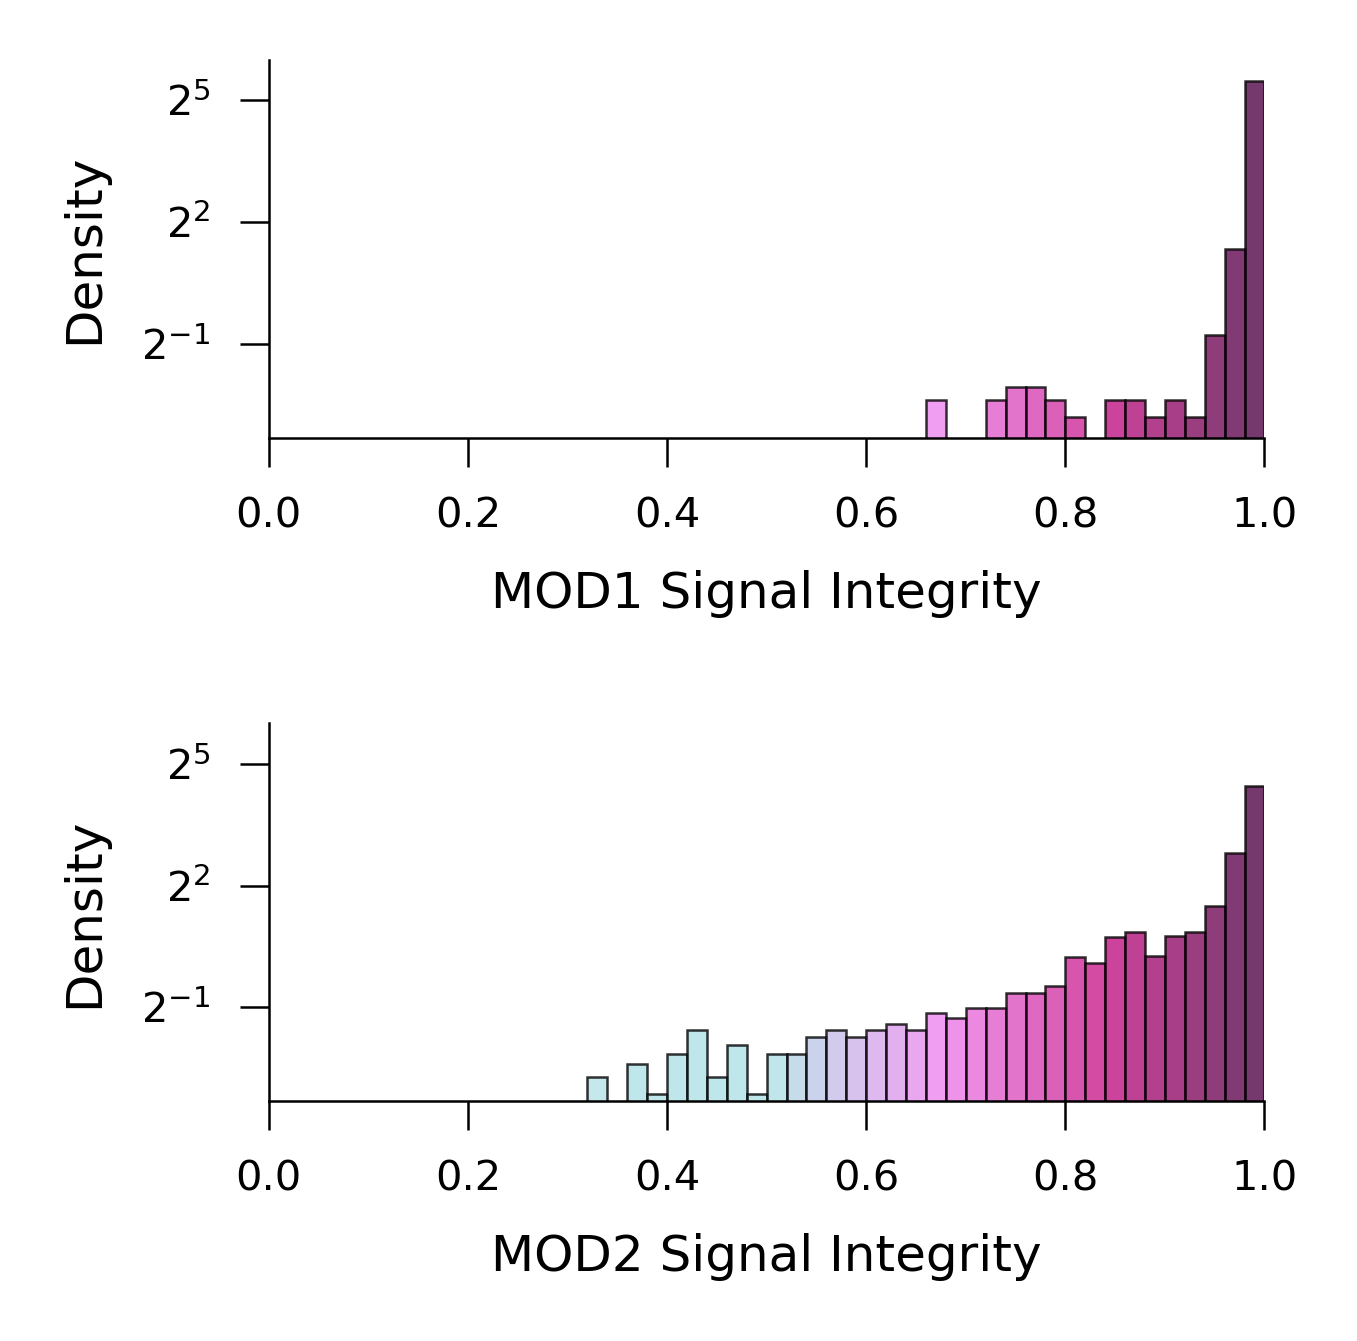

In [165]:
vals1, bins1, vals2, bins2 = plot_vsi_distribution_comparison(
    cell_integrity_1=MOD1_int,
    cell_strength_1=MOD1_str,
    cell_integrity_2=MOD2_int,
    cell_strength_2=MOD2_str,
    signal_threshold=3.0,
    figure_height=6/2.54,
    cmap="BIH",
    ylim=(1e-1,64)
)

### MOD1 marker transcripts

In [ ]:
import matplotlib.lines as mlines

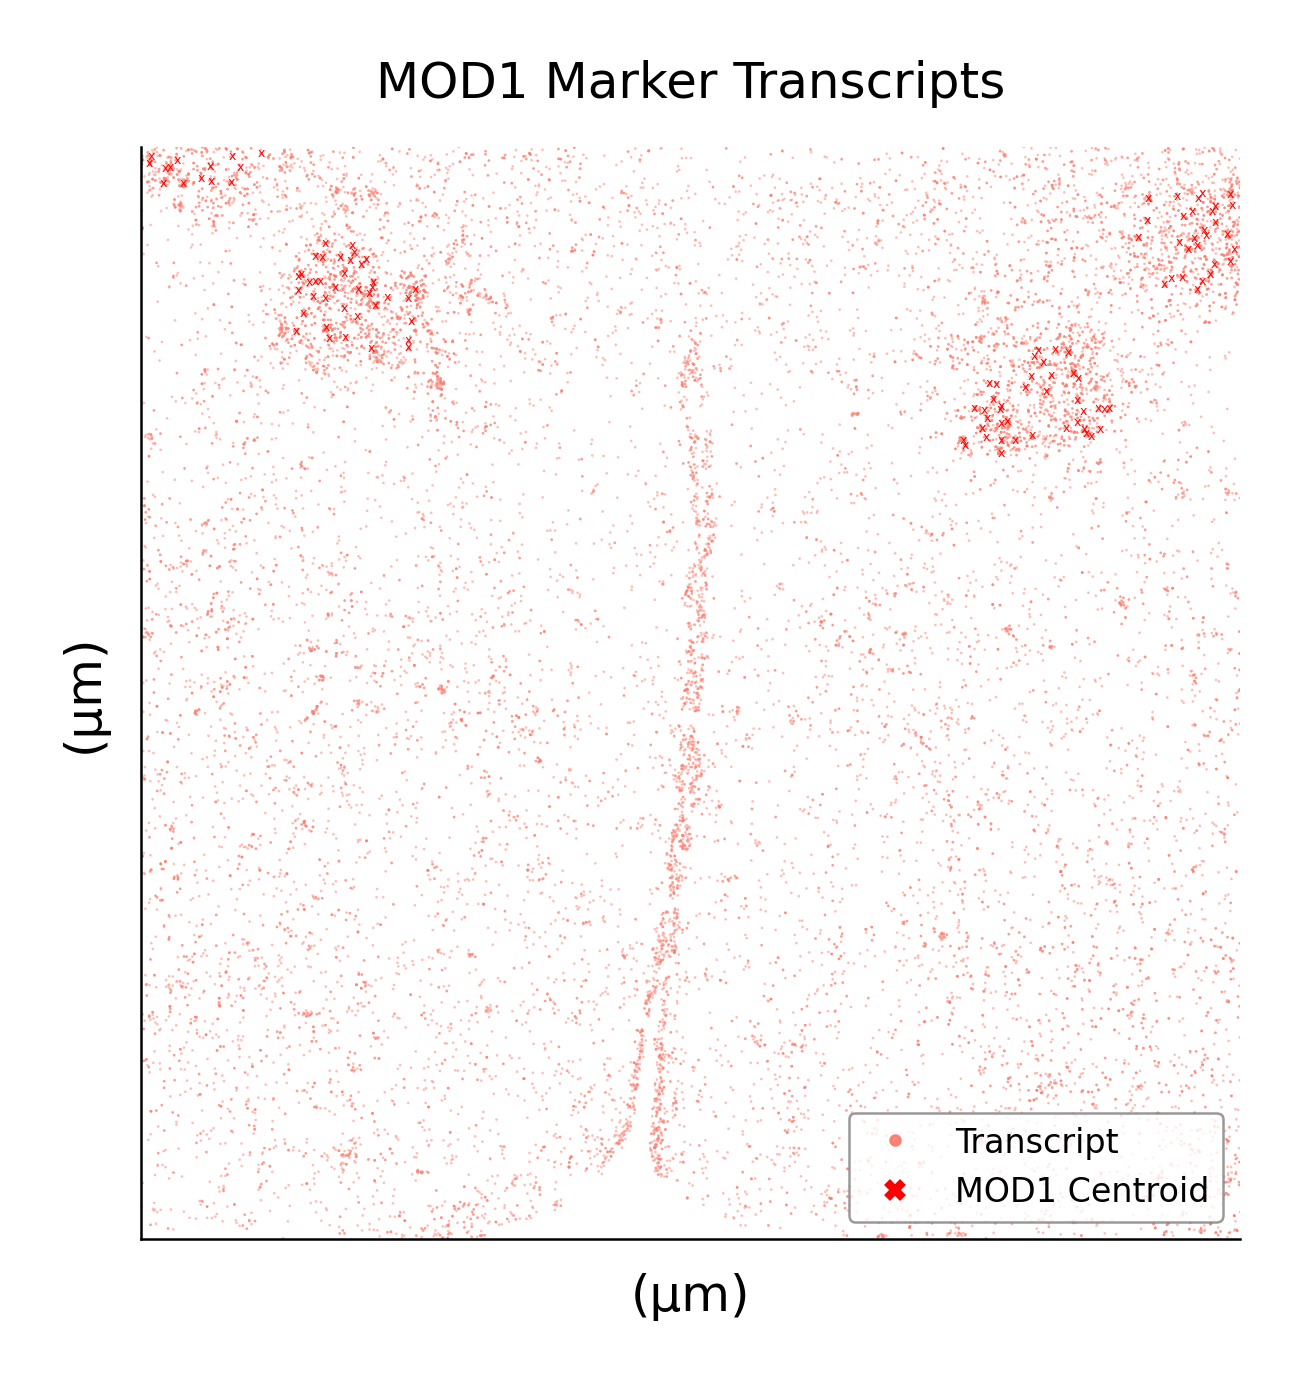

In [196]:
plt.figure(figsize=(6/2.54, 6/2.54), dpi=600)

plt.scatter(
    MOD1_signals["x"],
    MOD1_signals["y"],
    s=0.1,
    c='salmon', 
    alpha=0.5,
    edgecolors='none'
)

for _, row in MOD1_df.iterrows():
    plt.text(
        row["x"], 
        row["y"], 
        "x", 
        fontsize=1.5, 
        color='red',
        ha='center', 
        va='center'
    )

# transcript_patch = mpatches.Patch(color='orange', label='Transcript')
centroid_text = mlines.Line2D([], [], color='red', marker='x', linestyle='None', markersize=2, label='MOD1 Centroid')
transcript_text = mlines.Line2D([], [], color='salmon', marker='o', linestyle='None', markersize=0.5, label='Transcript')

legend = plt.legend(
    handles=[transcript_text, centroid_text],
    loc='lower right',
    fontsize=4,
    frameon=True
)

legend.get_frame().set_linewidth(0.3)
legend.get_frame().set_edgecolor('grey')

plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel("(μm)", fontsize=6)
plt.ylabel("(μm)", fontsize=6)
plt.xticks([])
plt.yticks([])
plt.title('MOD1 Marker Transcripts', fontsize=6)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_linewidth(0.3)


plt.show()

### MOD2 marker transcripts

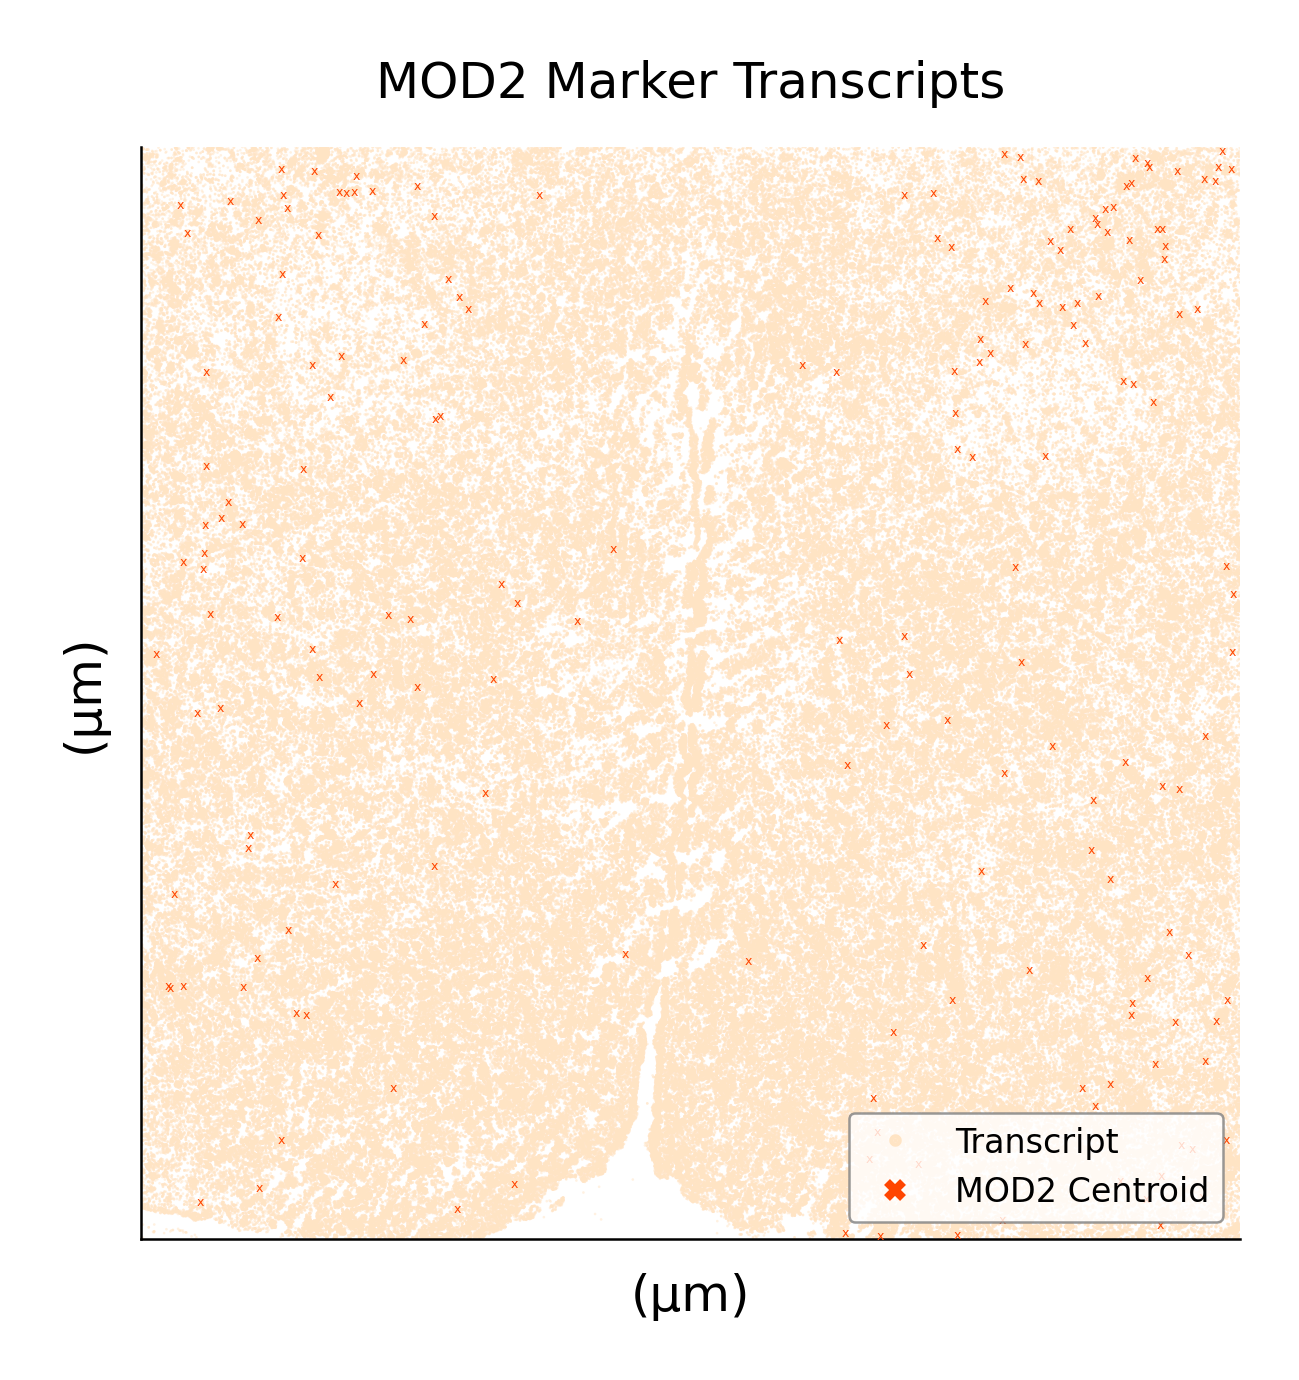

In [ ]:
plt.figure(figsize=(6/2.54, 6/2.54), dpi=600)

plt.scatter(
    MOD2_signals["x"],
    MOD2_signals["y"],
    s=0.1,
    c='bisque', 
    alpha=0.5,
    edgecolors='none'
)

for _, row in MOD2_df.iterrows():
    plt.text(
        row["x"], 
        row["y"], 
        "x", 
        fontsize=1.5, 
        color='orangered',
        ha='center', 
        va='center'
    )

centroid_text = mlines.Line2D([], [], color='orangered', marker='x', linestyle='None', markersize=2, label='MOD2 Centroid')
transcript_text = mlines.Line2D([], [], color='bisque', marker='o', linestyle='None', markersize=0.5, label='Transcript')

legend = plt.legend(
    handles=[transcript_text, centroid_text],
    loc='lower right',
    fontsize=4,
    frameon=True
)

legend.get_frame().set_linewidth(0.3)
legend.get_frame().set_edgecolor('grey')

plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel("(μm)", fontsize=6)
plt.ylabel("(μm)", fontsize=6)
plt.xticks([])
plt.yticks([])
plt.title('MOD2 Marker Transcripts', fontsize=6)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_linewidth(0.3)


plt.show()

### Heatmap for Marker Expression in scRNA-seq data

In [202]:
noOD_sc_data = pd.concat([sc_DE, sc_cell_class], axis=1)
noOD_sc_data = noOD_sc_data[~noOD_sc_data['Cell_class'].str.startswith("OD")]

noOD_sc_cell_class = noOD_sc_data['Cell_class']
noOD_sc_data = noOD_sc_data.drop('Cell_class', axis=1)

In [ ]:
def plot_annotate_heatmap(cluster_data, cluster_labels, gene_groups=None, zscore=True, cmap=HEATMAP_CMAP,
                          box_specs=None, cluster_text_y=-1.2, show_cluster=True,
                          show_cluster_lines=True, DE_g_line=True):

    # Data preprocessing
    cluster_data = cluster_data.copy()
    cluster_data['Cell_class'] = cluster_labels

    cluster_data = cluster_data.sort_values(by='Cell_class')
    cell_class_col = cluster_data['Cell_class']
    numeric_data = cluster_data.drop(columns=['Cell_class']).apply(pd.to_numeric, errors='coerce')
    numeric_data = numeric_data.dropna(axis=1).loc[:, ~numeric_data.T.duplicated()]
    cluster_data = pd.concat([cell_class_col, numeric_data], axis=1)

    expression_data = cluster_data.drop('Cell_class', axis=1).T
    expression_data = expression_data.loc[:, ~expression_data.columns.duplicated()]

    cluster_labels_sorted = cluster_data['Cell_class'].values
    unique_labels = sorted(set(cluster_labels_sorted))

    # Normalize
    if zscore:
        expression_data = expression_data.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
        vmin, vmax = -3, 3
    else:
        vmin, vmax = 0, 5

    # Reorder cells within cluster
    new_order = []
    for label in unique_labels:
        indices = np.where(cluster_labels_sorted == label)[0]
        subset = expression_data.iloc[:, indices]
        if subset.shape[1] > 1:
            linkage_matrix = linkage(subset.T, method='ward')
            sorted_indices = indices[leaves_list(linkage_matrix)]
        else:
            sorted_indices = indices
        new_order.extend(sorted_indices)

    reordered_expression_data = expression_data.iloc[:, new_order]
    reordered_cluster_labels = cluster_labels_sorted[new_order]

    # Reorder genes
    if gene_groups is not None:
        new_gene_order = []
        for label in sorted(set(gene_groups['cluster'])):
            gene_indices = np.where(gene_groups == label)[0]
            subset = reordered_expression_data.iloc[gene_indices, :]
            if subset.shape[0] > 1:
                linkage_matrix = linkage(subset, method='average')
                sorted_gene_indices = gene_indices[leaves_list(linkage_matrix)]
            else:
                sorted_gene_indices = gene_indices
            new_gene_order.extend(sorted_gene_indices)
    else:
        new_gene_order = leaves_list(linkage(reordered_expression_data, method='average'))

    reordered_expression_data = reordered_expression_data.iloc[new_gene_order, :]

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(20, 10), dpi=600)
    sns.heatmap(
        reordered_expression_data,
        vmin=vmin, vmax=vmax,
        cmap=cmap,
        xticklabels=False,
        yticklabels=True,
        cbar=True,
        ax=ax,
        cbar_kws={"shrink": 0.5}
    )

    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, rotation=0)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Annotate cluster
    cluster_boundaries = []
    for label in unique_labels:
        indices = np.where(reordered_cluster_labels == label)[0]
        if len(indices) == 0:
            continue
        start, end = indices[0], indices[-1]
        x_pos = (start + end) / 2
        if show_cluster:
            ax.text(x_pos, cluster_text_y, str(label), ha='center', va='center', rotation=90, fontsize=15)
        cluster_boundaries.append(end)

    if show_cluster_lines:
        for boundary in cluster_boundaries[:-1]:
            ax.axvline(x=boundary + 0.5, color='purple', linestyle='--', linewidth=1)

    if DE_g_line:
        ax.hlines(y=9, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='green', linestyle='--', linewidth=1)

    if box_specs is not None:
        ax_pos = ax.get_position()
        y_rect = ax_pos.y0 - 0.1
        height = ax_pos.height * 18.15
        for box in box_specs:
            rect = patches.Rectangle(
                (ax_pos.x0 + box["x_offset"], y_rect),
                box["width"], height,
                linewidth=1.5,
                edgecolor=box["color"],
                facecolor='none',
                linestyle=box.get("linestyle", '--')
            )
            ax.add_patch(rect)

    plt.show()

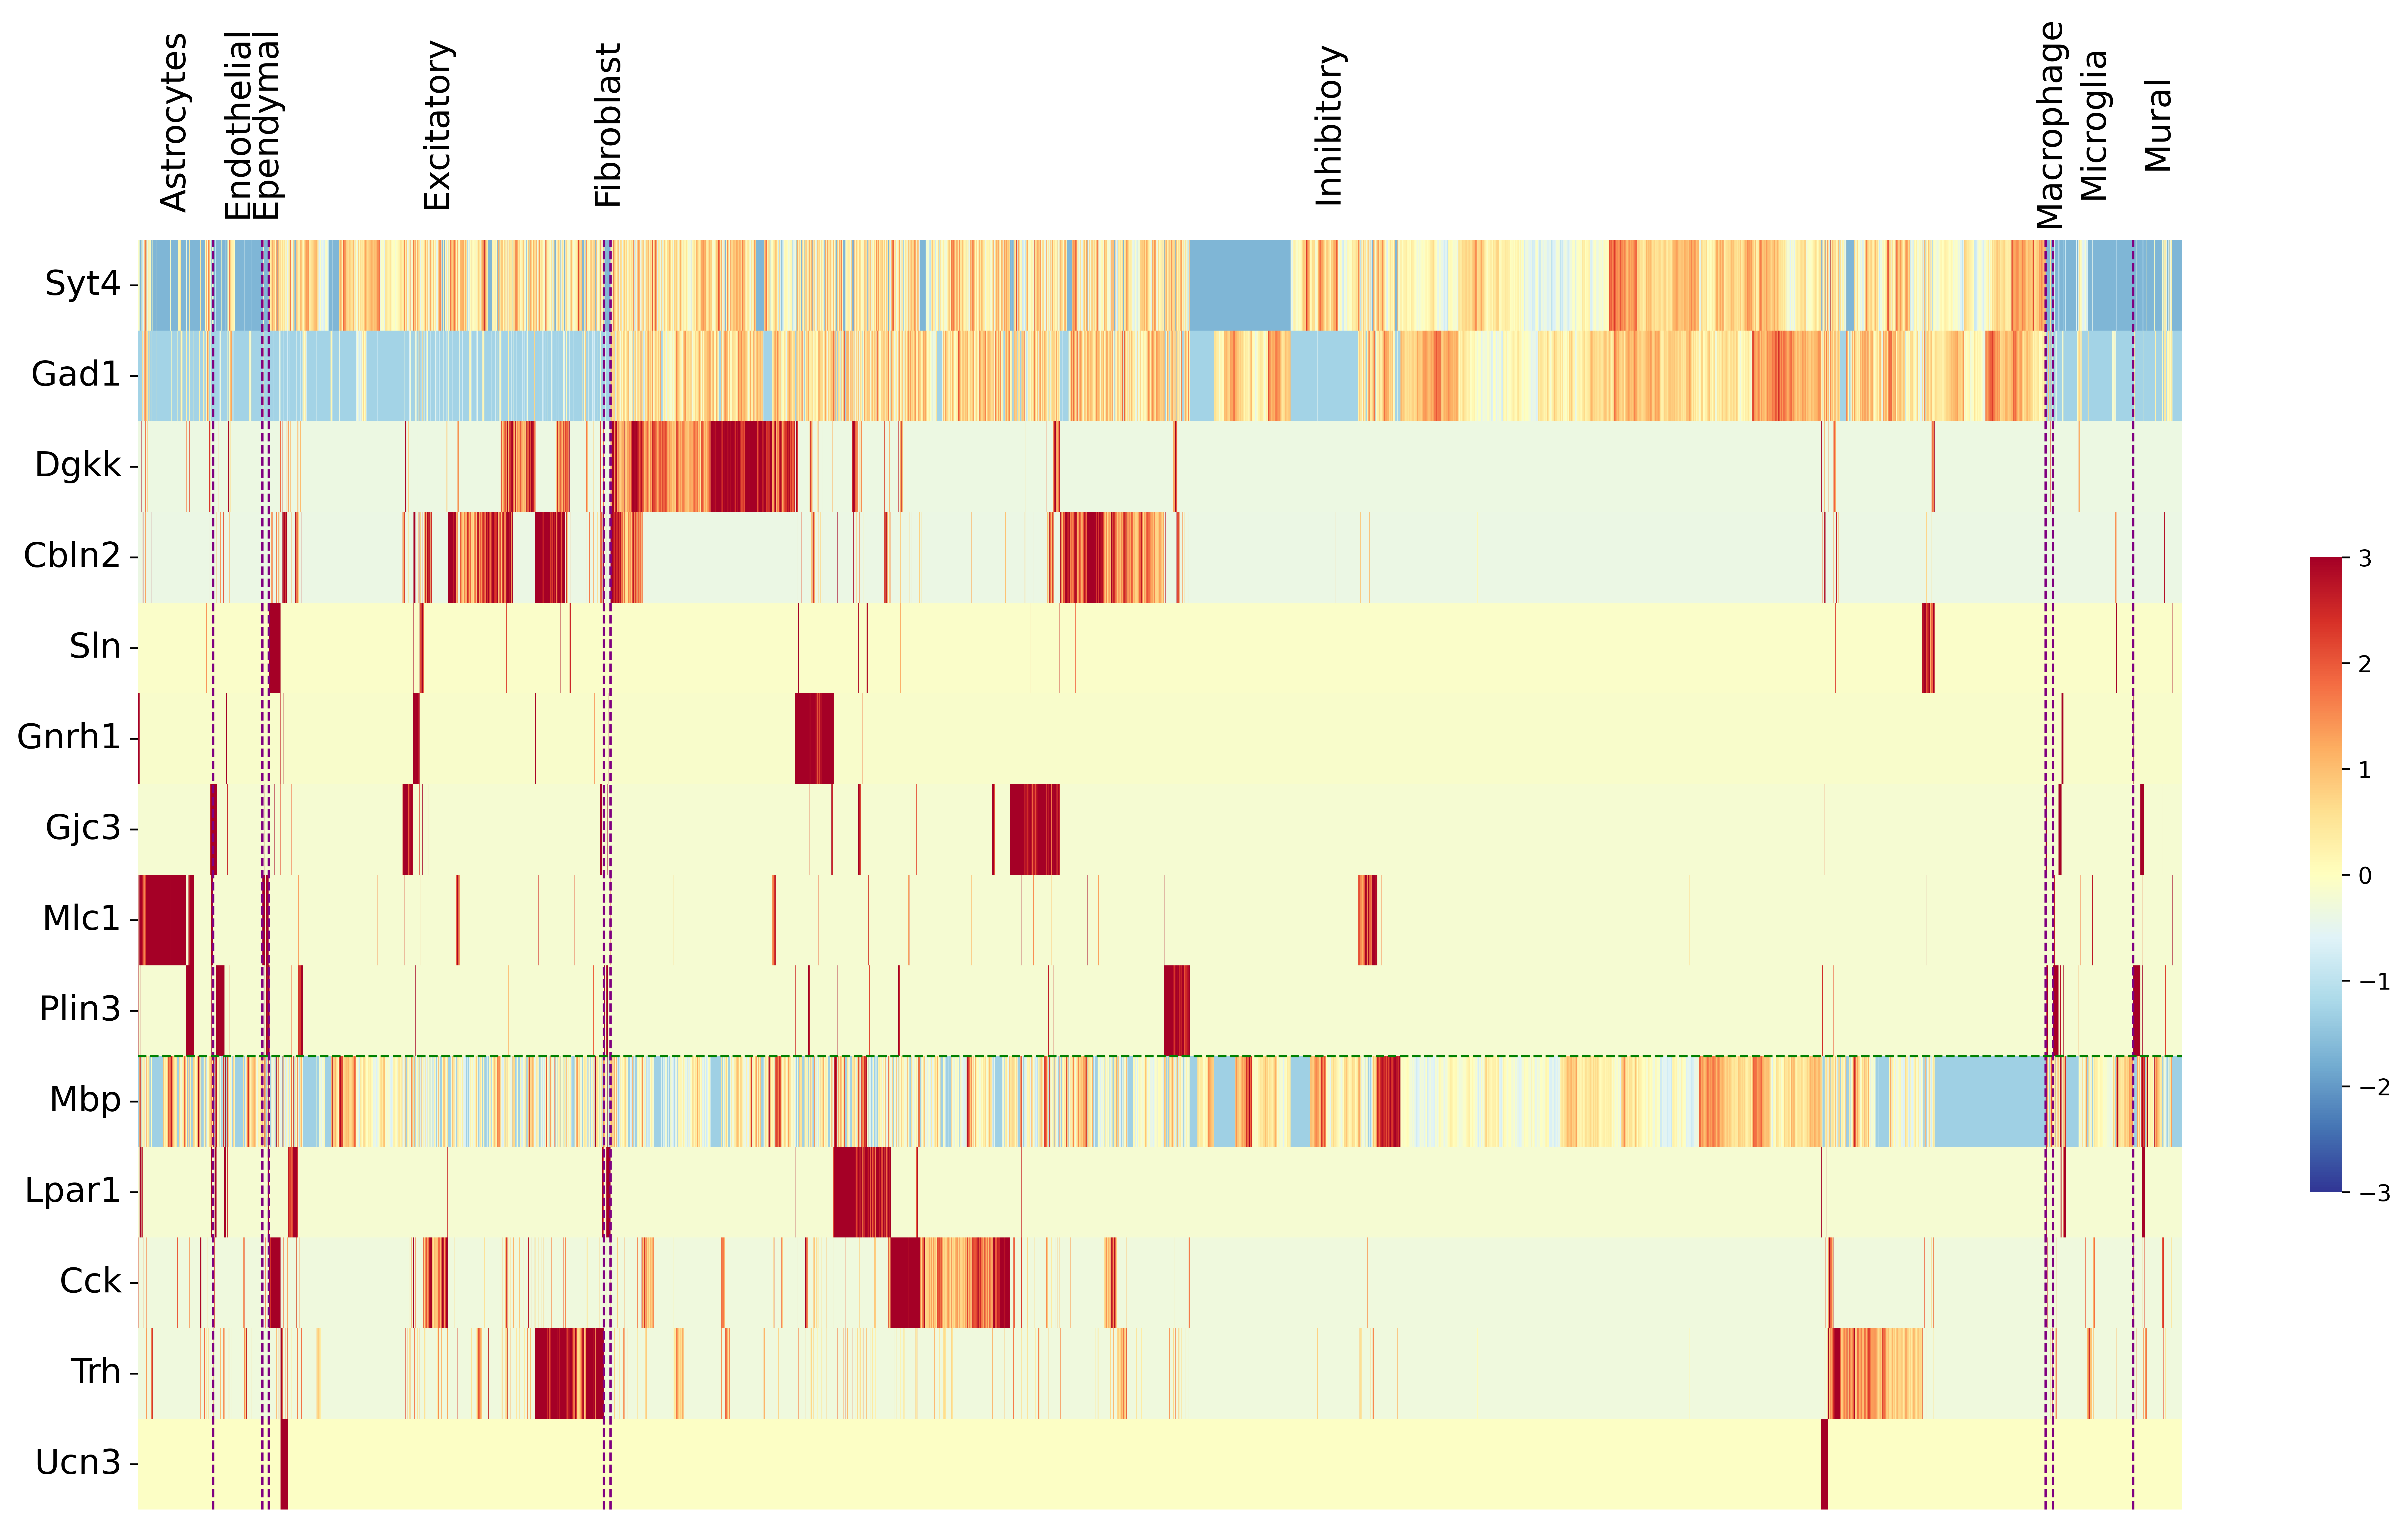

In [203]:
plot_annotate_heatmap(cluster_data = noOD_sc_data, cluster_labels=noOD_sc_cell_class, gene_groups=Gene_Group, cluster_text_y=-1.3)

### Doublets

#### UMAP

#### Cell Map

#### Doublet1: Inhibitory

#### Doublet2: Excitatory